# MINST Digit Classification
---

Rohit Baney    
7th June 2021

---

The MINST dataset is known as the 'hello world' of computer vision datasets. 

The following Deep Neural Network is my attempt at Digit Classification using a Convolutional Neural Network (CNN).

The goal of this project is to successfully classify images of handwritten digits using a neural network. 

More information about the dataset can be found here: https://www.kaggle.com/scolianni/mnistasjpg

---

In [1]:
#Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import  Sequential
from tensorflow.keras import layers 
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import seaborn as sns

In [2]:
#Importing data
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

train.shape, test.shape

((42000, 785), (28000, 784))

In [3]:
#Creating Train and Test arays
y = train.iloc[:,0].values.astype('int32') #Extracting values in order to store data as array
X = train.iloc[:,1:].values.astype('float32')
X_test = test.values.astype('float32')

## Data Prep

---

After extracting the data and storing them as arrays, we need to reshape the data so that it can be fed into a CNN. 

We reshape the data in the form (example_number, height, width, channel)

Height and width can be derived by taking the square root of the number of columns in the dataset. That is to say, that since each row in the dataset contains data for a single image, then the number of columns is the total number of pixels in the image. In our example, we have 784 columns in each row, i.e. 784 pixels per image. In a square format (which is the format the images are in) this comes to images of the size 28x28 (sqrt(784) == 28).

Additionally, for X_train and X_test, we divide the data by 255 in order to constain it between 0 and 1. We choose 255 because in an image, this number represents the maximum value for a pixel's intensity. 0 represents a white pixel and 1 represents a black one. Numbers in between represent various shades of grey. 

For y_train, we onehot encode the data using the handy 'to_categorical' function from keras.utils.np_utils.

---

In [4]:
#Constraining data between 0 and 1
X = X / 255.0
X_test = X_test / 255.0

#Reshaping data in the form (example, width, height, channel)
X = X.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

#Converting y using onehot encoding
y = to_categorical(y)
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

---
After restructuring the data, we now split our data into train and test sets. Upon doing so, we can then construct a generator for both the training and testing data that feeds our model with batches of our data for training. 

Additionally, we'll augment the data using ImageDataGenerator.

---

In [5]:
#Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

#Instantiate generator and data augmentation
generator = ImageDataGenerator(rotation_range=8, 
                               width_shift_range=0.08, 
                               shear_range=0.3,
                               height_shift_range=0.08, 
                               zoom_range=0.08
                              )

#Create batch generators for train and validation sets
train_batches = generator.flow(X_train, y_train, 
                               batch_size = 64)

val_batches = generator.flow(X_val, y_val, 
                             batch_size = 64)

## Model Creation

---
THe model we are going to use is an optimized CNN along with learning rate decay and early stopping. The architecture of the model can be found on this notebook: https://www.kaggle.com/sajaldeb25/kaggle-digit-recognizer-my-best-model-cnn-999. All credits to the author of that notebook for figuring out optimal parameters. 

Note to beginners:    
I was confused at first between the difference between using .fit and .fit_generator. The difference is that the latter is used when the dataset is extremely large. It divides the dataset into batches to be used by the model and only stores the data being used by the current batch to memory. This enables us to work with extremely large datasets with limited amounts of memory. 

---

In [6]:
#Callbacks
#Early Stopping 
early_stopping = EarlyStopping(min_delta=0.001, 
                               patience=10, 
                               restore_best_weights=True) #Use this if you don't have a GPU

#Learning Rate Reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [7]:
#Model Creation
#Model Architecture can be found here: https://www.kaggle.com/sajaldeb25/kaggle-digit-recognizer-my-best-model-cnn-999. 
#All credits for architecture to the author. A lot of time and effort went into optimization of the model and all the hyperparameters. 

model2 = Sequential([
    layers.Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)),
    layers.BatchNormalization(),
    layers.Conv2D(filters = 64, kernel_size = (5,5), padding = 'Same', activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    layers.Dense(10, activation = 'softmax')
])

#Define Optimizer
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


#Compile Model
model2.compile(optimizer = optimizer,
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

#Fit Model
history = model2.fit_generator(
    generator=train_batches, 
    steps_per_epoch=525,
    epochs=50,  
    validation_data=val_batches, 
    validation_steps=100,
    callbacks = [learning_rate_reduction]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
525/525 [==============================] - 33s 52ms/step - loss: 0.5172 - accuracy: 0.8346 - val_loss: 0.1732 - val_accuracy: 0.9488
Epoch 2/50
525/525 [==============================] - 26s 50ms/step - loss: 0.0878 - accuracy: 0.9735 - val_loss: 0.0538 - val_accuracy: 0.9841
Epoch 3/50
525/525 [==============================] - 27s 51ms/step - loss: 0.0615 - accuracy: 0.9804 - val_loss: 0.0596 - val_accuracy: 0.9841
Epoch 4/50
525/525 [==============================] - 27s 51ms/step - loss: 0.0477 - accuracy: 0.9862 - val_loss: 0.0557 - val_accuracy: 0.9845
Epoch 5/50
525/525 [==============================] - 27s 51ms/step - loss: 0.0480 - accuracy: 0.9850 - val_loss: 0.0467 - val_accuracy: 0.9887
Epoch 6/50
525/525 [==============================] - 27s 51ms/step - loss: 0.0419 - accuracy: 0.9872 - val_loss: 0.0443 - val_accuracy: 0.9884
Epoch 7/50
525/525 [==============================] - 27s 51ms/step - loss: 0.0364 - accuracy: 0.9883 - val_loss: 0.0309 - val_accuracy:

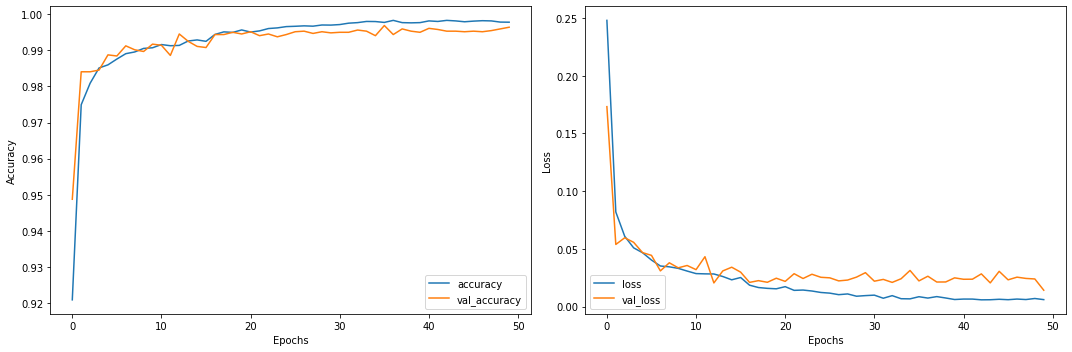

In [8]:
#Plotting the results

plt.figure(figsize = (15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
# plt.yticks(np.linspace(0.96,0.995))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='lower left')


plt.tight_layout()
plt.show()

## Creating Submission File

In [9]:
#Making Predictions for test set
predictions = model2.predict_classes(X_test)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [10]:
#Creating dataframe and saving it as a .csv file to submit
submission_data = pd.DataFrame({'ImageId': range(1,28001), 'Label': predictions})
submission_data.to_csv("Submission_Digit_Recognition_model2.csv", index=False, header=True)

## Conclusion

The model above got me an accuracy of 0.99503.

Methods to improve upon this model:
- Use an ensemble of CNNs
- Use data augmentation.
- A useful tutorial for doing the above can be found here: https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist

Notebooks referred to:    
https://www.kaggle.com/poonaml/deep-neural-network-keras-way    
https://www.kaggle.com/abhiram8/mnist-digit-classification-cnn-beginner-s-guide    
https://www.kaggle.com/sajaldeb25/kaggle-digit-recognizer-my-best-model-cnn-999    
https://www.kaggle.com/c/digit-recognizer/discussion/61480    

I hope this notebook was helpful to you. Please comment if there are any questions or if I can help you in any way.

Thank you for reading!